# Data Extraction and Combination

Notebook to perform tasks to extract, simplify, combine, and analyze land data from several sources.

## Data Sources

- Land Area figures for New Hampshire: NH GRANIT system; compiled at [NH Office of Strategic Initiatives](https://www.nh.gov/osi/planning/services/gis/maps.htm), May 2021
- New Hampshire Political Boundaries at 1:24,000 Scale: [NH GRANIT system](https://granit.unh.edu/cgi-bin/nhsearch?dset=pb&#47;nh)
- New Hampshire Conservation/Public Lands at 1:24,000 Scale: [NH GRANIT system](https://www.granit.unh.edu/cgi-bin/nhsearch?dset=consnh&#47;nh)
    - [Interactive map](https://data-nhgranit.opendata.arcgis.com/datasets/new-hampshire-conservation-public-lands/explore?location=43.117182%2C-71.544725%2C13.00)

## Package Imports and Helper Functions

In [1]:
# Package imports
import os
import numpy as np
import pandas as pd
import shapely
import geopandas as gpd
import geemap

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_columns', 50)

In [2]:
# Helper function to convert square feet to acres
def sq_ft_to_acres(sq_ft):
    """
    Returns area in acres when square feet are input.
    :param sq_ft: numeric type, area in square feet
    :return: float, area in acres
    """
    conv_factor = 43560.0
    return sq_ft / conv_factor

## Data Imports

In [3]:
# Import land area data
land_area = pd.read_csv('./data/NH-land-area-figures-consolidated.csv',
                        header=3)

In [4]:
land_area.head()

,County,Municipality,Total acres,Total sq. miles,Land acres,Land sq. miles,Water acres,Water sq. miles
0,Belknap,Alton,53230.5,83.17,40636.10,63.49,12594.40,19.68
1,Belknap,Barnstead,28758.7,44.94,27215.21,42.52,1543.49,2.41
2,Belknap,Belmont,20427.6,31.92,19190.38,29.98,1237.22,1.93
3,Belknap,Center Harbor,10394.4,16.24,8498.05,13.28,1896.35,2.96
4,Belknap,Gilford,34243.7,53.51,24786.22,38.73,9457.48,14.78


In [5]:
land_area.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   County           259 non-null    object 
 1   Municipality     259 non-null    object 
 2   Total acres      259 non-null    float64
 3   Total sq. miles  259 non-null    float64
 4   Land acres       259 non-null    float64
 5   Land sq. miles   259 non-null    float64
 6   Water acres      259 non-null    float64
 7   Water sq. miles  259 non-null    float64
dtypes: float64(6), object(2)
memory usage: 16.3+ KB


In [6]:
total_areas = land_area.groupby(['County']).sum()
total_areas

,Total acres,Total sq. miles,Land acres,Land sq. miles,Water acres,Water sq. miles
County,,,,,,
Belknap,300786.19,469.98,256443.63,400.68,44342.57,69.28
Carroll,635817.97,993.47,595805.22,930.95,40012.76,62.52
Cheshire,466514.34,728.94,450805.97,704.39,15708.39,24.54
Coos,1171969.27,1831.21,1148425.31,1794.41,23543.98,36.77
Grafton,1119743.95,1749.59,1093489.36,1708.56,26254.63,41.02
Hillsborough,571152.78,892.46,555882.47,868.58,15270.34,23.85
Merrimack,611148.30,954.92,593770.15,927.73,17378.17,27.12
Rockingham,465182.48,726.86,445326.83,695.83,19855.68,31.01
Strafford,244860.75,382.60,233827.90,365.36,11032.86,17.23


In [7]:
# Create mapping of County name to ID number
county_map = pd.DataFrame({'COUNTY_ID': range(1, 20, 2),
                           'COUNTY_NAME': list(total_areas.index)})
county_map

,COUNTY_ID,COUNTY_NAME
0,1,Belknap
1,3,Carroll
2,5,Cheshire
3,7,Coos
4,9,Grafton
5,11,Hillsborough
6,13,Merrimack
7,15,Rockingham
8,17,Strafford
9,19,Sullivan


In [8]:
# Import political boundaries (pb) data
pbp_path = '../../NH_PoliticalBoundaries/GRANIT_20220220160347/pbp.shp'  # Polygons

pb_poly = gpd.read_file(pbp_path, driver='shapefile')

In [9]:
print(pb_poly.shape)
pb_poly.head()

(259, 6)


,FIPS,NAME,RPA,ACRES,COUNTY,geometry
0,7160,Pittsburg,1,186430.5,7,"POLYGON ((1063158.250 1002584.875, 1063233.000..."
1,7040,Clarksville,1,39915.8,7,"POLYGON ((1059756.000 928359.250, 1059898.250 ..."
2,7005,Atkinson & Gilmanton,1,12351.3,7,"POLYGON ((1111451.250 916720.625, 1111518.250 ..."
3,7190,Stewartstown,1,30019.1,7,"POLYGON ((1019728.688 911317.500, 1019769.188 ..."
4,7175,Second College,1,26773.9,7,"POLYGON ((1117369.750 895118.500, 1117506.500 ..."


In [10]:
# Change NAME column name so unambiguous when 
#    combined with public land DataFrame
cols = list(pb_poly.columns)
cols[1] = 'TOWN_NAME'
pb_poly.columns = cols

In [11]:
# Check CRS
pb_poly.crs

<Derived Projected CRS: PROJCS["NAD83 / New Hampshire (ftUS)",GEOGCS["NAD8 ...>
Name: NAD83 / New Hampshire (ftUS)
Axis Info [cartesian]:
- [east]: Easting (US survey foot)
- [north]: Northing (US survey foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

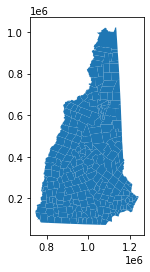

In [12]:
pb_poly.plot()

In [13]:
# Data check: Pittsburg area in sq ft and acres
p_name = pb_poly.loc[0, 'TOWN_NAME']
pitts_sqft = pb_poly.loc[0, 'geometry'].area

print(f'{p_name} sq ft: {pitts_sqft}')
print(f'{p_name} acres: {sq_ft_to_acres(pitts_sqft)}')

Pittsburg sq ft: 8120912285.074219
Pittsburg acres: 186430.4932294357


In [14]:
# Import public and conservation land (pcl) data
pcl_path = '../../NH_PublicConservationLand/GRANIT_20220220154602/consnh.shp'

public = gpd.read_file(pcl_path, driver='shapefile')

In [15]:
print(public.shape)
public.head()

(12591, 39)


,SHAPE_Leng,SHAPE_Area,TID,NAME,NAMEALT,P_NAME,P_NAMEALT,PPTYPE,PPTERMTYPE,PPTERM,SPTYPE1,SPTYPE2,PPAGENCY,PPAGENTYPE,SPAGENCY1,SPAGENCY2,RSIZE,CSIZE,P_RSIZE,P_CSIZE,PROGRAM,LEVEL_,MSTATUS,SOURCE,ACCURACY,COBKPG,DATEREC1,DATEREC2,ACCESS,DATEADDED,DATEALTER,NOTES1,NOTES2,NOTES3,NOTES4,PID,GAP_STATUS,OWNERTYPE,geometry
0,83426.545022,2.163150e+08,006-004 -002,Connecticut Lakes WMA North (West),None,Connecticut Lakes Natural Area,Connecticut Lakes Headwaters,FO,P,-98,CE,CE,32000,3,52010,31000,-999.0,4965.930,25000.0,25001.000,7,1,3,NH DRED/SURVEY,1,07/1018/197,20021230,None,1,20050117,20170418,"Other Programs: LCHIP, N.A. Wetlands Conservat...",BOUNDARY ADJUSTED TO MEET 2009 DRED SURVEY CT ...,Boundary updated to match 006-001 -001,None,006-004 -,3,3,"POLYGON ((1099405.625 1002946.688, 1099033.625..."
1,61619.397201,4.721541e+07,006-004 -003,Connecticut Lakes WMA North (East),None,Connecticut Lakes Natural Area,Connecticut Lakes Headwaters,FO,P,-98,CE,CE,32000,3,52010,31000,-999.0,1083.920,25000.0,25001.000,7,1,3,NH DRED/SURVEY,1,07/1018/197,20021230,None,1,20050117,20170418,"Other Programs: LCHIP, N.A. Wetlands Conservat...",BOUNDARY ADJUSTED TO MEET 2009 DRED SURVEY CT ...,Boundary updated to match 006-001 -001,None,006-004 -,3,3,"POLYGON ((1108214.134 1000715.787, 1108214.125..."
2,22319.159084,4.695122e+06,006-001 -004,Connecticut Lakes State Forest,None,Connecticut Lakes State Forest,None,FO,U,-99,None,None,31000,3,0,0,-999.0,107.786,1531.0,1530.510,0,1,2,USGS,2,07/284/376,19351104,None,1,None,20170418,NH DRED,BOUNDARIES UPDATED WITH DATA SENT FROM NH F&G ...,Boundary and attributes updated by NH DRED,None,006-001 -,2,3,"POLYGON ((1102884.216 960520.713, 1102849.300 ..."
3,7552.234495,3.371443e+06,006-002 -001,Fourth Connecticut Lake Preserve,None,Fourth Connecticut Lake Preserve,None,FO,U,-99,None,None,52010,5,0,0,78.1,77.398,78.1,77.398,0,1,1,SURVEY,2,None,1990,None,1,None,20050117,BOUNDARIES UPDATED WITH DATA SENT FROM NH F&G,None,None,None,006-002 -,1,5,"POLYGON ((1101565.750 1002827.688, 1100987.125..."
4,31544.856081,1.836509e+07,006-003 -001,Norton Pool Preserve,None,Norton Pool Preserve,None,FO,U,-99,None,None,52010,5,0,0,-999.0,421.606,427.1,422.936,0,1,1,SURVEY,1,None,1986,None,1,None,None,1 OF 2 TRACTS,None,None,None,006-003 -,1,5,"POLYGON ((1126678.250 982401.250, 1126702.250 ..."


In [16]:
public.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12591 entries, 0 to 12590
Data columns (total 39 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   SHAPE_Leng  12591 non-null  float64 
 1   SHAPE_Area  12591 non-null  float64 
 2   TID         12591 non-null  object  
 3   NAME        12591 non-null  object  
 4   NAMEALT     1110 non-null   object  
 5   P_NAME      12591 non-null  object  
 6   P_NAMEALT   336 non-null    object  
 7   PPTYPE      12591 non-null  object  
 8   PPTERMTYPE  12591 non-null  object  
 9   PPTERM      12591 non-null  int64   
 10  SPTYPE1     2460 non-null   object  
 11  SPTYPE2     290 non-null    object  
 12  PPAGENCY    12591 non-null  int64   
 13  PPAGENTYPE  12591 non-null  int64   
 14  SPAGENCY1   12591 non-null  int64   
 15  SPAGENCY2   12591 non-null  int64   
 16  RSIZE       12591 non-null  float64 
 17  CSIZE       12591 non-null  float64 
 18  P_RSIZE     12591 non-null  float64 
 

In [17]:
public.crs

<Derived Projected CRS: PROJCS["NAD83 / New Hampshire (ftUS)",GEOGCS["NAD8 ...>
Name: NAD83 / New Hampshire (ftUS)
Axis Info [cartesian]:
- [east]: Easting (US survey foot)
- [north]: Northing (US survey foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [18]:
# Counts by primary protecting agency
"""
1 Municipal/County
2 Federal
3 State
4 Other Public/Quasi-Public Entity
5 Private
"""

public.groupby('PPAGENTYPE').size()

PPAGENTYPE
1    5612
2     767
3    1461
4     247
5    4504
dtype: int64

In [19]:
# Counts by owner type
"""
1 Municipal
2 Federal
3 State
4 Other Public/Quasi-Public Entity
5 Private
6 County
9 Uknown
"""
public.groupby('OWNERTYPE').size()

OWNERTYPE
1    4135
2     413
3    1019
4     290
5    6660
6      47
9      27
dtype: int64

In [20]:
#TODO: bar charts for protecting agency type and owner type

## Create County Boundaries

In [21]:
# Check column names of political boundaries DF
pb_poly.head(2)

,FIPS,TOWN_NAME,RPA,ACRES,COUNTY,geometry
0,7160,Pittsburg,1,186430.5,7,"POLYGON ((1063158.250 1002584.875, 1063233.000..."
1,7040,Clarksville,1,39915.8,7,"POLYGON ((1059756.000 928359.250, 1059898.250 ..."


<AxesSubplot:>

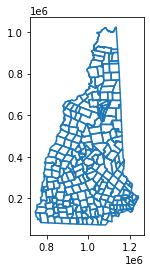

In [22]:
pb_poly.boundary.plot()

In [23]:
pb_poly.shape

(259, 6)

In [24]:
# Create GeoDataFrame for county info
counties = gpd.GeoDataFrame(county_map)
counties

,COUNTY_ID,COUNTY_NAME
0,1,Belknap
1,3,Carroll
2,5,Cheshire
3,7,Coos
4,9,Grafton
5,11,Hillsborough
6,13,Merrimack
7,15,Rockingham
8,17,Strafford
9,19,Sullivan


In [25]:
# Loop over pb_poly, select rows by county, combine polygons
for idx, row in counties.iterrows():
    counties.loc[idx, 'geometry'] = pb_poly[pb_poly['COUNTY'] == row['COUNTY_ID']]['geometry'].unary_union

In [26]:
# Set CRS
counties.crs = pb_poly.crs
counties.crs

<Derived Projected CRS: PROJCS["NAD83 / New Hampshire (ftUS)",GEOGCS["NAD8 ...>
Name: NAD83 / New Hampshire (ftUS)
Axis Info [cartesian]:
- [east]: Easting (US survey foot)
- [north]: Northing (US survey foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [27]:
counties

,COUNTY_ID,COUNTY_NAME,geometry
0,1,Belknap,"POLYGON ((1015148.688 347257.250, 1014901.375 ..."
1,3,Carroll,"POLYGON ((1126799.250 391095.000, 1126683.000 ..."
2,5,Cheshire,"POLYGON ((834911.250 80684.172, 831492.125 808..."
3,7,Coos,"POLYGON ((1060894.500 610400.000, 1060746.250 ..."
4,9,Grafton,"POLYGON ((929173.375 397185.125, 924505.500 39..."
5,11,Hillsborough,"POLYGON ((974770.125 75048.172, 974622.500 750..."
6,13,Merrimack,"POLYGON ((983544.125 237690.438, 979663.375 23..."
7,15,Rockingham,"POLYGON ((1147664.000 118687.047, 1147544.000 ..."
8,17,Strafford,"POLYGON ((1167108.250 212985.000, 1166733.250 ..."
9,19,Sullivan,"POLYGON ((807159.375 239479.156, 806776.875 23..."


<AxesSubplot:>

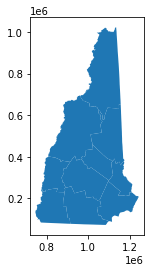

In [28]:
counties.plot()

In [29]:
# Sanity-check county area size against Total Acres data
area_check = total_areas.loc[:, ['Total acres']]
area_check.reset_index(inplace=True)
area_check['Calcd acres'] = counties.area.apply(sq_ft_to_acres)
area_check['Check'] = area_check['Total acres'] - area_check['Calcd acres']

area_check

,County,Total acres,Calcd acres,Check
0,Belknap,300786.19,3.007859e+05,0.319617
1,Carroll,635817.97,6.358181e+05,-0.132222
2,Cheshire,466514.34,4.665139e+05,0.405549
3,Coos,1171969.27,1.171969e+06,0.629583
4,Grafton,1119743.95,1.119743e+06,0.518849
5,Hillsborough,571152.78,5.711522e+05,0.624471
6,Merrimack,611148.30,6.111477e+05,0.560993
7,Rockingham,465182.48,4.651709e+05,11.598277
8,Strafford,244860.75,2.448606e+05,0.114671
9,Sullivan,353361.90,3.533620e+05,-0.067761


## Find Intersection of Towns and Public Land Tracts

Given the nature of some public or conservation land tracts, they don't all neatly fall within town/municipality boundaries. For example, the White Mountain National Forest overlaps several towns. To find the intersection of public/conservation land tracts with towns, a simple `overlay` method is employed, with the `keep_geom_type` parameter set to `True` so results are only of type `Polygon` or `MultiPolygon`.

In [30]:
# Overlay town and public land DataFrames by intersections,
#    keeping only polygon results
public_by_town = pb_poly.overlay(public,
                                 how='intersection',
                                 keep_geom_type=True)

public_by_town.shape

(14322, 44)

In [31]:
public_by_town.head()

,FIPS,TOWN_NAME,RPA,ACRES,COUNTY,SHAPE_Leng,SHAPE_Area,TID,NAME,NAMEALT,P_NAME,P_NAMEALT,PPTYPE,PPTERMTYPE,PPTERM,SPTYPE1,SPTYPE2,PPAGENCY,PPAGENTYPE,SPAGENCY1,SPAGENCY2,RSIZE,CSIZE,P_RSIZE,P_CSIZE,PROGRAM,LEVEL_,MSTATUS,SOURCE,ACCURACY,COBKPG,DATEREC1,DATEREC2,ACCESS,DATEADDED,DATEALTER,NOTES1,NOTES2,NOTES3,NOTES4,PID,GAP_STATUS,OWNERTYPE,geometry
0,7160,Pittsburg,1,186430.5,7,83426.545022,2.163150e+08,006-004 -002,Connecticut Lakes WMA North (West),None,Connecticut Lakes Natural Area,Connecticut Lakes Headwaters,FO,P,-98,CE,CE,32000,3,52010,31000,-999.0,4965.930,25000.0,25001.000,7,1,3,NH DRED/SURVEY,1,07/1018/197,20021230,None,1,20050117,20170418,"Other Programs: LCHIP, N.A. Wetlands Conservat...",BOUNDARY ADJUSTED TO MEET 2009 DRED SURVEY CT ...,Boundary updated to match 006-001 -001,None,006-004 -,3,3,"POLYGON ((1092850.250 1009334.188, 1092882.000..."
1,7160,Pittsburg,1,186430.5,7,61619.397201,4.721541e+07,006-004 -003,Connecticut Lakes WMA North (East),None,Connecticut Lakes Natural Area,Connecticut Lakes Headwaters,FO,P,-98,CE,CE,32000,3,52010,31000,-999.0,1083.920,25000.0,25001.000,7,1,3,NH DRED/SURVEY,1,07/1018/197,20021230,None,1,20050117,20170418,"Other Programs: LCHIP, N.A. Wetlands Conservat...",BOUNDARY ADJUSTED TO MEET 2009 DRED SURVEY CT ...,Boundary updated to match 006-001 -001,None,006-004 -,3,3,"POLYGON ((1103644.750 1004199.875, 1103676.000..."
2,7160,Pittsburg,1,186430.5,7,22319.159084,4.695122e+06,006-001 -004,Connecticut Lakes State Forest,None,Connecticut Lakes State Forest,None,FO,U,-99,None,None,31000,3,0,0,-999.0,107.786,1531.0,1530.510,0,1,2,USGS,2,07/284/376,19351104,None,1,None,20170418,NH DRED,BOUNDARIES UPDATED WITH DATA SENT FROM NH F&G ...,Boundary and attributes updated by NH DRED,None,006-001 -,2,3,"POLYGON ((1102849.300 960221.990, 1102723.656 ..."
3,7160,Pittsburg,1,186430.5,7,7552.234495,3.371443e+06,006-002 -001,Fourth Connecticut Lake Preserve,None,Fourth Connecticut Lake Preserve,None,FO,U,-99,None,None,52010,5,0,0,78.1,77.398,78.1,77.398,0,1,1,SURVEY,2,None,1990,None,1,None,20050117,BOUNDARIES UPDATED WITH DATA SENT FROM NH F&G,None,None,None,006-002 -,1,5,"POLYGON ((1099639.500 1002925.375, 1099744.750..."
4,7160,Pittsburg,1,186430.5,7,31544.856081,1.836509e+07,006-003 -001,Norton Pool Preserve,None,Norton Pool Preserve,None,FO,U,-99,None,None,52010,5,0,0,-999.0,421.606,427.1,422.936,0,1,1,SURVEY,1,None,1986,None,1,None,None,1 OF 2 TRACTS,None,None,None,006-003 -,1,5,"POLYGON ((1126702.250 981997.125, 1125584.000 ..."


## Aggregate Public Land Acreage by Town

In [38]:
town_public_acreage = public_by_town[['FIPS', 'TOWN_NAME', 'RPA', 'ACRES', 'COUNTY', 'geometry']]
town_public_acreage = town_public_acreage.dissolve(by='TOWN_NAME')
town_public_acreage.shape

(259, 5)

In [39]:
town_public_acreage.head()

,geometry,FIPS,RPA,ACRES,COUNTY
TOWN_NAME,,,,,
Acworth,"MULTIPOLYGON (((805248.375 251015.594, 805229....",19005,3,24998.9,19
Albany,"MULTIPOLYGON (((1064814.108 515038.907, 106476...",3005,1,48475.6,3
Alexandria,"MULTIPOLYGON (((944264.973 381748.004, 944400....",9005,2,27921.2,9
Allenstown,"MULTIPOLYGON (((1042935.373 229454.572, 104292...",13005,5,13167.4,13
Alstead,"MULTIPOLYGON (((803722.000 212039.328, 802883....",5005,4,25210.9,5


In [40]:
town_public_acreage['PUBLIC_ACRES'] = town_public_acreage['geometry'].area.apply(sq_ft_to_acres)

In [41]:
town_public_acreage['PCT_PUBLIC'] = town_public_acreage['PUBLIC_ACRES'] / town_public_acreage['ACRES']

<AxesSubplot:>

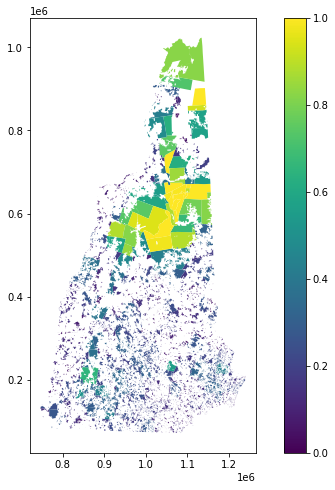

In [46]:
# Quick heatmap based on public land percent
town_public_acreage.plot('PCT_PUBLIC',
                         legend=True,
                         figsize=(10, 8))

## Map Tracts and Town/County Borders

In [32]:
# Polygon styling

# County borders
county_style = {
    "stroke": True,
    "color": "#000000",
    "weight": 6,
    "opacity": 1,
    "fill": False
}

# Town borders
town_style = {
    "stroke": True,
    "color": "#404040",  # Onyx (dark gray)
    "weight": 2,
    "opacity": 1,
    "fill": False,
}

# Tracts
tract_style = {
    "stroke": True,
    "color": "#FC6B03",  # Burnt orange
    "weight": 1,
    "opacity": 1,
    "fill": False,
    "fillColor": "#FC6B03",
    "fillOpacity": 0.4,
}

In [33]:
# Find the centroid of NH to center map

# Get WGS 84 centroid of state (returns Point object)
nh_centroid = counties['geometry'].to_crs('epsg:4326').unary_union.centroid

# Grab latitude and longitude from centroid Point
nh_lon = nh_centroid.x
nh_lat = nh_centroid.y

# Create list needed for map parameters
nh_center = [nh_lat, nh_lon]

In [34]:
# Create geojson data for map
county_geojson = counties.to_crs('epsg:4326').__geo_interface__
town_geojson = pb_poly.to_crs('epsg:4326').__geo_interface__
public_geojson = public_by_town.to_crs('epsg:4326').__geo_interface__

In [35]:
# Create a basemap
m = geemap.Map(center=nh_center,
               zoom=8)

m.add_geojson(county_geojson, style=county_style, layer_name='County')
m.add_geojson(town_geojson, style=town_style, layer_name='Town/Municipality')

m

Map(center=[43.6856382281176, -71.57756125989133], controls=(WidgetControl(options=['position', 'transparent_b…

In [36]:
m.add_geojson(public_geojson, style=tract_style, layer_name='Public/Conservation Land')